<a href="https://colab.research.google.com/github/vitakot/comparing_returns/blob/master/R_vs_Zorro_Returns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Here I'm trying to summarize techniques used for computing returns and compare results obtained by R and Zorro Trader.

In [41]:
# lists of libraries
dependencies <- c(
  "pacman", "ttr","iterators", "R.methodsS3", "openssl", "foreach", "xts", "R.oo", "R.utils"
)

libs_to_load <- c("tidyverse", "lubridate", "purrr", "stringr", "zoo", "glue", "here")

# capitalisation of call to CRAN may not always match capitalisation of package name (eg library(doParallel) vs sudo apt install r-cran-doparallel).
install_from_cran <- gsub("^(?!R\\.)([\\w]+)", "\\L\\1", unique(c(libs_to_load, dependencies)), perl = TRUE)  # convert to lowercase all letters other than an "R" at the start followed by "."

msg1 <- system2('sudo', args = c('apt-get', 'update'),
  stdout = TRUE,
  stderr = TRUE,
  wait = TRUE
)

msg2 <- system2(
  'sudo', 
  args = c('apt', 'install', sub('', 'r-cran-', install_from_cran, '-y --fix-missing')),
  stdout = TRUE,
  stderr = TRUE,
  wait = TRUE
)

pacman::p_load(char = libs_to_load, install = FALSE)

# Set chart options
options(repr.plot.width = 14, repr.plot.height=7)
theme_set(theme_bw())
theme_update(text = element_text(size = 20))

Let's start with the simplest case - returns from being long only in BTC. 

First load file coinmetrics_btc_xrp.csv from a public folder on my Google Drive: https://drive.google.com/drive/folders/1SyNJ0cA4_BzQ2ZRT5WfA4hzGrr3kImg2?usp=share_link

 The file contains daily close prices for BTC and XRP.

In [42]:
system("gdown --id 1T-C19juxNaTUF7irnzuZFm4Zcqsm4EHp")
prices <- read.csv("coinmetrics_btc_xrp.csv", header = TRUE, sep = ",", stringsAsFactors = FALSE)
head(prices)

# kepp BTC only
prices <- prices %>% filter(ticker %in% c('BTC'))
prices$date <- lubridate::date(prices$date)
prices <- prices %>% filter(date >= as.Date("2020-07-19"))

,ticker,date,price_usd,market_cap
,<chr>,<chr>,<dbl>,<dbl>
1,BTC,2010-07-18,0.08584000,295959.2
2,BTC,2010-07-19,0.08080000,279285.2
3,BTC,2010-07-20,0.07473573,259000.4
4,BTC,2010-07-21,0.07919286,275266.5
5,BTC,2010-07-22,0.05846976,203749.6
6,BTC,2010-07-23,0.06059287,211735.7


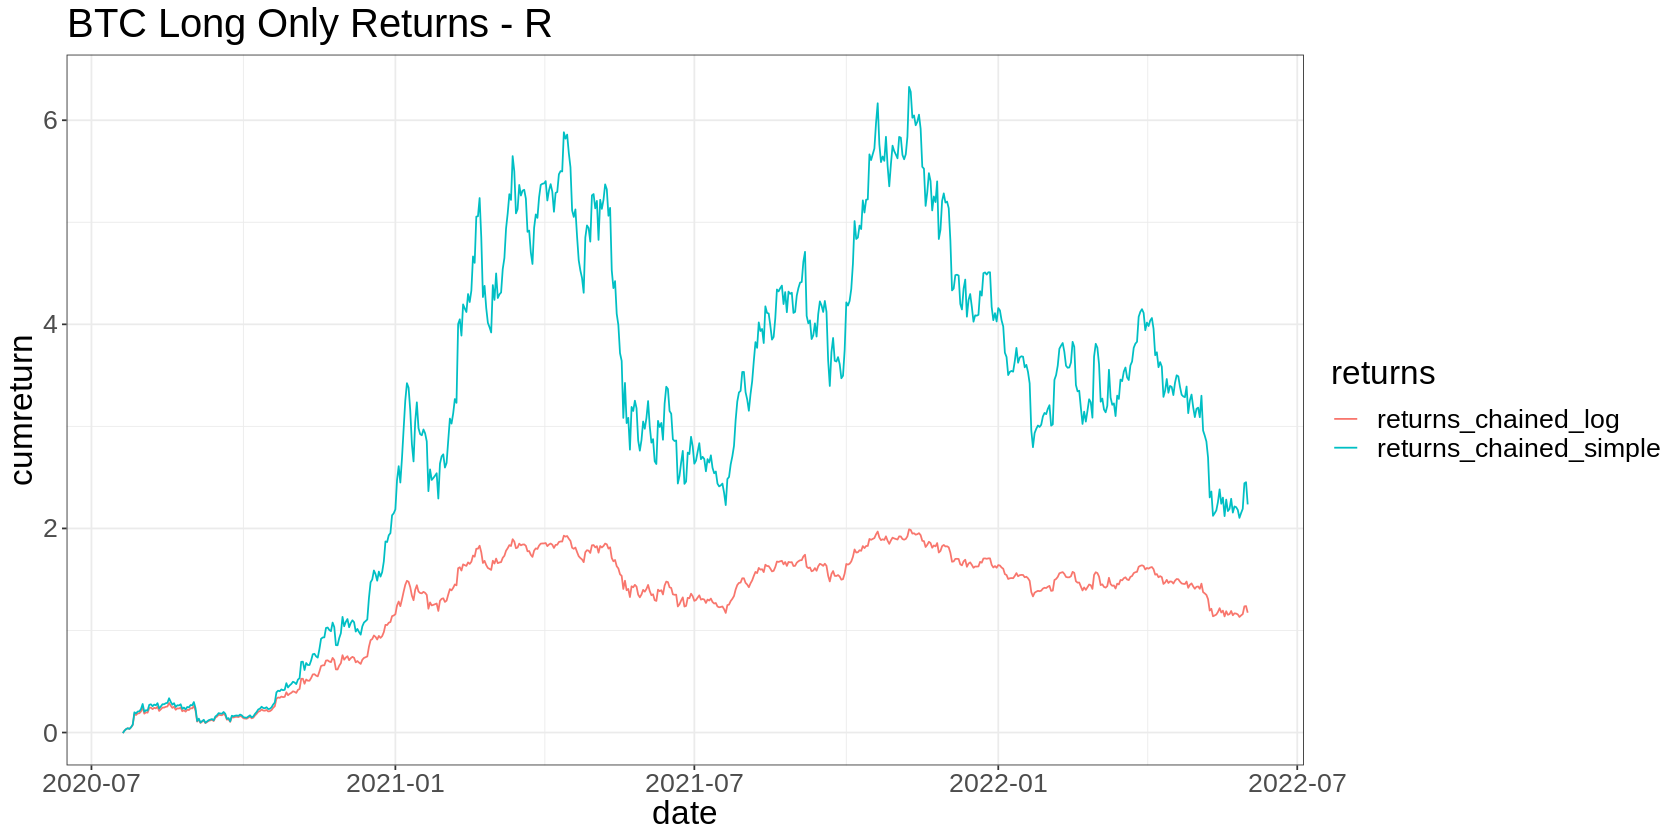

In [46]:
# copmute log and simple returns
returns <- prices %>%
  mutate(
    returns_log = log(price_usd / lag(price_usd)),
    returns_simple = (price_usd / lag(price_usd) - 1),
  ) %>%
  na.omit()

# copmute cumulative returns
returns <- returns %>% 
  mutate(
    returns_chained_log  = cumsum(returns_log),
    returns_chained_simple = cumprod( 1 + (returns_simple)) - 1,
    ) 

returns %>%
pivot_longer(starts_with('returns_chained'), names_to = 'returns', values_to = 'cumreturn') %>%
ggplot(aes(x=date, y=cumreturn, color = returns)) + 
geom_line() + 
ggtitle('BTC Long Only Returns - R')

In the analysis we use two types of returns:

* Simple returns = the returns. It corresponds to the situation when we stay **All-In**, i.e. each day we calculate returns on a bigger and bigger amount of money.
* Log returns are always smaller than simple returns. It corresponds to the situation when we constantly **rebalance** the position to be the same size.


In the above Figure "BTC Log Only Returns" we can seen it. 

Let's simulate both cases in the **Zorro trader**! I its done by this script: https://github.com/vitakot/comparing_returns/blob/master/returns_compare_single.cpp

Required data file BTC-PERP.t6 is on the mentioned Google Drive. Load and visualize results for both cases:

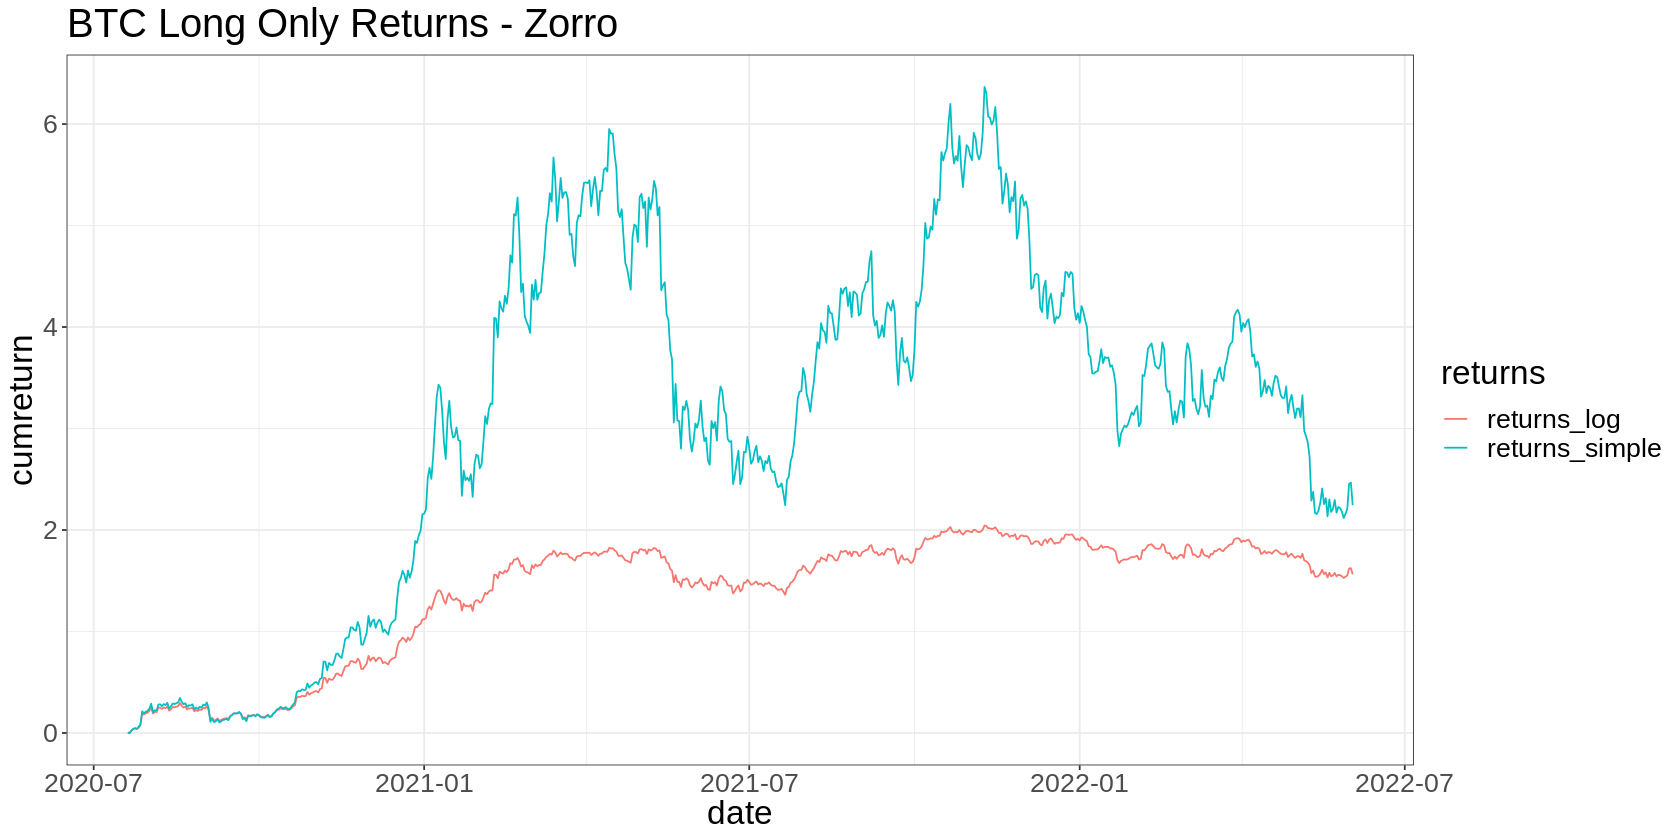

In [45]:
# file zorro_returns_compare_allin.csv
system("gdown --id 1TEiBPEYdQ0RvAJCjxmcNEXY6j9D7Way9")

# file zorro_returns_compare_rebalance.csv
system("gdown --id 1TBK9jtpakoBab7S5lXM8KJUDKfLPk82H")

zorro_returns_allin <- read.csv("zorro_returns_compare_allin.csv", header = TRUE, sep = ",", stringsAsFactors = FALSE)
zorro_returns_rebalance <- read.csv("zorro_returns_compare_rebalance.csv", header = TRUE, sep = ",", stringsAsFactors = FALSE)

zorro_returns <- zorro_returns_allin
colnames(zorro_returns) <- c('timestamp','returns_simple')
zorro_returns$returns_log <- zorro_returns_rebalance$returns
zorro_returns$date <- as.Date(as.POSIXct(zorro_returns$timestamp, origin="1970-01-01"))

zorro_returns %>%
  pivot_longer(starts_with('returns_'), names_to = 'returns', values_to = 'cumreturn') %>%
  ggplot(aes(x=date, y=cumreturn, color = returns)) + 
  geom_line() + 
  ggtitle('BTC Long Only Returns - Zorro')

We can see that returns computed by R and Zorro perpectly match and we are happy! 😀 🕺